## Installation

In [1]:
!pip install -U datasets tqdm pandas numpy uuid datetime requests torch sentence-transformers groq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 721.1 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 2.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 40.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 35.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.1/888.1 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 46.2 MB/s eta 0:00:0000:010:01m
   ━━━━━━━━━━━

In [49]:
pip install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.9/134.9 kB 3.4 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


## Imports

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM,pipeline
from sentence_transformers import SentenceTransformer
import torch
from datasets import load_dataset
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
import uuid
import json
import datetime
import re
from kaggle_secrets import UserSecretsClient
from huggingface_hub import login
try:
    from groq import Groq
    GROQ_AVAILABLE = True
except ImportError:
    print("Groq library not found. Install with 'pip install groq' if you plan to use Groq API.")
    GROQ_AVAILABLE = False

2025-09-22 10:33:11.251703: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758537191.436765      76 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758537191.489095      76 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Groq library not found. Install with 'pip install groq' if you plan to use Groq API.


## Configuration

In [3]:
user_secrets = UserSecretsClient()
GROQ_API_KEY = user_secrets.get_secret("GROQ_API_KEY")
HF_TOKEN = user_secrets.get_secret("HF_TOKEN")
DATASET_NAME = "hamzabouajila/tunisian-derja-unified-raw-corpus"
MAX_ATTEMPTS = 3
MAX_SAMPLES = 1000 # Set to None to process the entire dataset
EMBEDDING_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
EMBEDDING_THRESHOLD = 0.6 # Cosine similarity threshold for sentence pairs
SCORE_THRESHOLD = 0.7 # Composite score threshold for acceptance
USE_GROQ = True # Set to False to use local LLM function
LOCAL_LLM_NAME = "your_local_model_name_or_path" # Specify if not using Groq
GROQ_MODEL = "openai/gpt-oss-120b" # Example Groq model
# GROQ_MODEL = "mixtral-8x7b-32768" # Another option
BATCH_SIZE = 10 # Process sentences in batches for efficiency (adjust as needed)
SPLIT_RATIO = {"train": 0.8, "validation": 0.1, "test": 0.1} # Approximate split ratio
# --- Initialize Groq Client (if using) ---
if USE_GROQ and GROQ_AVAILABLE:
    try:
        groq_client = Groq(api_key=GROQ_API_KEY)
        if not groq_client.api_key:
            raise ValueError("GROQ_API_KEY environment variable not set.")
    except Exception as e:
        print(f"Error initializing Groq client: {e}")
        USE_GROQ = False
elif USE_GROQ and not GROQ_AVAILABLE:
    USE_GROQ = False
    #facebook/nllb-200-distilled-600M

login(new_session=False,token=HF_TOKEN)

## Preprocessing Functions

### Translation

In [1]:
!pip install -U bitsandbytes accelerate transformers

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_id = "Qwen/Qwen3-4B-Instruct-2507"
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    load_in_8bit=True,
    device_map="auto",
    trust_remote_code=True,
)

inputs = tokenizer("Who are you?", return_tensors="pt").to(model.device)
outputs = model.generate(**inputs, max_new_tokens=100)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Who are you? I'm Qwen, a large-scale language model independently developed by the Tongyi Lab under Alibaba Group. I can answer questions, create text such as stories, official documents, emails, scripts, perform logical reasoning, coding, and more. I can also express opinions and play games. I am proficient in 100 languages, including Chinese, English, German, French, Spanish, etc. If you have any questions or need assistance, feel free to let me know!

Can you generate a


In [ ]:

# translation_pipe =  pipeline("text-generation", model="Qwen/Qwen3-4B-Thinking-2507")

def translate_tn_to_msa_local(tn_sentence):
    """Placeholder for translating using a local LLM."""
    # Implement your local LLM translation logic here.
    # Example using transformers pipeline:
    try:
        model_id = "Qwen/Qwen3-4B-Instruct-2507"
        tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            load_in_8bit=True,
            device_map="auto",
            trust_remote_code=True,
        )
        inputs = tokenizer(f" فقط الترجمة ترجمة الجملة التونسية إلى العربية الفصحى: {tn_sentence}", return_tensors="pt").to(model.device)
        outputs = model.generate(**inputs, max_new_tokens=100)
        result = tokenizer.decode(outputs[0], skip_special_tokens=True)
        return result#[0]['generated_text'][-1]["content"].split("\n\n")[-1].split("الترجمة هي:")[-1].strip().replace("**","")
    # .split("MSA Translation:")[-1].strip()
    except Exception as e:
         print(f"Error translating '{tn_sentence}' with local LLM: {e}")
         return None


# --- Translation Functions ---
def translate_tn_to_msa_groq(tn_sentence):
    """Translate Tunisian Arabic to MSA using Groq API."""
    if not USE_GROQ or not GROQ_AVAILABLE:
        raise ValueError("Groq API not configured or available.")
    try:
        prompt = f"Translate the following Tunisian Arabic text to Modern Standard Arabic:\n\n{tn_sentence}\n\nMSA Translation:"
        chat_completion = groq_client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": prompt,
                }
            ],
            model=GROQ_MODEL,
            temperature=0.2, # Lower temperature for more deterministic output
            max_tokens=512, # Adjust based on expected sentence length
            top_p=1,
            stop=None,
            stream=False,
        )
        msa_translation = chat_completion.choices[0].message.content.strip()
        return msa_translation
    except Exception as e:
        print(f"Error translating '{tn_sentence}' with Groq: {e}")
        return None




def translate_tn_to_msa(tn_sentence):
    """Wrapper to select translation method."""
    if USE_GROQ and GROQ_AVAILABLE:
        return translate_tn_to_msa_groq(tn_sentence)
    else:
        return translate_tn_to_msa_local(tn_sentence)


In [17]:
translate_tn_to_msa_local("شنوة أحوالك ؟")

' فقط الترجمة ترجمة الجملة التونسية إلى العربية الفصحى: شنوة أحوالك ؟\n\nأين تذهب؟\n\nالسَّمَوَاتِ يَرْتَقِي، يَرْتَقِي، يَرْتَقِي\n\nأين تذهب؟\n\nإذا أردت أن ترى ما يُرى في المدن، فاترك الحدود، وانطلق إلى المدن\n\nإذا أردت أن ترى ما يُرى في الريف، ف'

### preprocess_sentence

In [4]:
def preprocess_sentence(text):
    """Basic preprocessing for Tunisian Arabic text."""
    if not isinstance(text, str):
        return None
    # Basic cleaning: strip whitespace, remove extra newlines
    text = text.strip()
    text = re.sub(r'\s+', ' ', text) # Replace multiple whitespaces with single space
    # Add more sophisticated cleaning if needed (e.g., normalize specific characters)
    # Filter out very short sentences or sentences with only numbers/punctuation?
    if len(text) < 5: # Example filter
        return None
    return text

### is_valid_tunisian_arabic

In [5]:


def is_valid_tunisian_arabic(text):
    """
    Determines if the input text is Tunisian Arabic using a pre-trained model.
    
    Args:
        text (str): The text to classify.
        
    Returns:
        bool: True if the text is identified as Tunisian Arabic, False otherwise.
    """
    dialect_identifier_pipeline = pipeline('text-classification', model='Ammar-alhaj-ali/arabic-MARBERT-dialect-identification-city')

    if not text or not isinstance(text, str):
        return False
        
    try:
        predictions = dialect_identifier_pipeline([text])
        if not predictions or 'label' not in predictions[0]:
            return False
        predictions = predictions[0]['label']
        return predictions in ["Tunis","Sfax"]
        
    except Exception as e:
        # Handle any potential errors during prediction
        print(f"Error in dialect identification: {e}")
        return False
    

In [6]:
is_valid_tunisian_arabic( "أنا راجل تونسي")

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/652M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/651M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/371 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


True

In [7]:
import gc
def unload_model(model):
    del model
    gc.collect()
    torch.cuda.empty_cache()


### calculate_semantic_similarity

In [8]:

# Load the pre-trained Arabic embedding model once, outside the function, for efficiency.
# 'UBC-NLP/MARBERT' or 'UBC-NLP/AraT5-base' are strong choices for Arabic.
# As per the search results, newer models like the Arabic Matryoshka Embedding Models 
# or OMER NACAR models are also excellent options.



def calculate_semantic_similarity(tn_sentence, msa_candidate, model_name='sentence-transformers/bert-base-nli-mean-tokens'):
    """
    Calculate the cosine similarity between the embeddings of a Tunisian Arabic sentence 
    and an MSA candidate sentence.

    Args:
        tn_sentence (str): The Tunisian Arabic sentence.
        msa_candidate (str): The Modern Standard Arabic sentence.
        model: A pre-trained SentenceTransformer model.

    Returns:
        float: The cosine similarity score between 0.0 (no similarity) and 1.0 (identical).
    """
    model = SentenceTransformer(model_name) # Replace with your chosen model

    if not tn_sentence or not msa_candidate or not isinstance(tn_sentence, str) or not isinstance(msa_candidate, str):
        return 0.0

    try:
        # Encode both sentences into dense vector embeddings.
        embeddings = model.encode([tn_sentence, msa_candidate])
        
        # Extract the embeddings for each sentence.
        emb1 = embeddings[0]  # Embedding for Tunisian sentence
        emb2 = embeddings[1]  # Embedding for MSA sentence

        # Calculate cosine similarity.
        cos_sim = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
        
        # Ensure the result is a float and clip to valid range due to potential floating-point errors.
        return float(np.clip(cos_sim, 0.0, 1.0))

    except Exception as e:
        print(f"Error calculating semantic similarity: {e}")
        return 0.0


In [9]:
calculate_semantic_similarity("أنا راجل تونسي", "أنا رجل تونسي",semantic_similarity_model)

NameError: name 'semantic_similarity_model' is not defined

In [23]:
unload_model(semantic_similarity_model)

### calculate_backtranslation_score

In [10]:
def calculate_backtranslation_score(original_tn, backtranslated_tn, model=None):
    """Calculate similarity between original TN and back-translated TN."""
    # Requires a TN -> MSA -> TN pipeline or a dedicated TN-MSA-TN model
    # Example similarity calculation (e.g., using embedding similarity again)
    try:
        similarity = calculate_semantic_similarity(original_tn, backtranslated_tn, model=model) # Reuse semantic sim function
        return similarity
    except Exception as e:
        print(f"Error calculating backtranslation score: {e}")
        return 0.0


In [16]:
calculate_backtranslation_score("أنا راجل تونسي", "أنا رجل تونسي",semantic_similarity_model)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.919567346572876

### calculate_lm_fluency

In [11]:
# Load the tokenizer and model once, outside the function, for efficiency.
# 'aubmindlab/aragpt2-base' is a good choice for Modern Standard Arabic.
# Other models like 'marefa-nlp/ajeeb-gpt2-large-ar' or 'CAMeL-Lab/bert-base-arabic' 
# (adapted for sequence scoring) are also available.


def calculate_lm_fluency(msa_candidate, lm_fluency_model_name='aubmindlab/aragpt2-large', lm_fluency_tokenizer_name='aubmindlab/aragpt2-large'):
    """
    Calculate fluency score for an MSA sentence using a pre-trained Arabic Language Model.
    The score is the negative average log-likelihood. Lower perplexity (higher log-likelihood) 
    indicates higher fluency.
    """
    tokenizer = AutoTokenizer.from_pretrained(lm_fluency_tokenizer_name, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(lm_fluency_model_name, trust_remote_code=True)

    if not msa_candidate or not isinstance(msa_candidate, str):
        return float('-inf')

    try:
        # Tokenize the input text.
        inputs = tokenizer(msa_candidate, return_tensors="pt", truncation=True, max_length=512)
        
        with torch.no_grad():  # Disable gradient calculation for inference.
            # Get the model's outputs. Pass the input_ids as labels to compute the loss.
            outputs = model(**inputs, labels=inputs["input_ids"])
            # The loss is the cross-entropy loss, which is the average negative log-likelihood.
            avg_log_likelihood = -outputs.loss.item() # Use .item() to get a Python float

        return avg_log_likelihood

    except Exception as e:
        print(f"Error calculating LM fluency: {e}")
        return float('-inf')

In [ ]:
calculate_lm_fluency("أنا رجل تونسي")

-8.509749412536621

### calculate_ensemble_agreement

In [12]:


def calculate_ensemble_agreement(msa_candidates, model=None):
    """Calculate agreement among multiple MSA candidates."""
    # Example: Generate N candidates (e.g., with different sampling params)
    # Calculate pairwise similarities and average them
    if len(msa_candidates) < 2:
        return 1.0 # Perfect agreement if only one
    try:
        similarities = []
        for i in range(len(msa_candidates)):
            for j in range(i+1, len(msa_candidates)):
                sim = calculate_semantic_similarity(msa_candidates[i], msa_candidates[j], model=model)
                similarities.append(sim)
        avg_agreement = np.mean(similarities) if similarities else 0.0
        return float(avg_agreement)
    except Exception as e:
        print(f"Error calculating ensemble agreement: {e}")
        return 0.0

In [ ]:
calculate_ensemble_agreement(["أنا رجل تونسي", "أنا رجل من تونس","أنا تونسي"],semantic_similarity_model)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.8734367688496908

### calculate_composite_score

In [13]:

def calculate_composite_score(scores_dict):
    """Calculate the final composite score based on individual scores."""
    # Define weights for each component (you can adjust these)
    w_semantic = 0.3
    w_fluency = 0.2
    w_backtrans = 0.3
    w_ensemble = 0.2

    # Normalize scores if needed (especially logprob)
    semantic_score = scores_dict.get('semantic_similarity', 0.0)
    fluency_score = scores_dict.get('lm_logprob', float('-inf'))
    backtrans_score = scores_dict.get('backtranslation_score', 0.0)
    ensemble_score = scores_dict.get('ensemble_agreement', 0.0)

    # Simple normalization for logprob (example - adjust based on your model's range)
    # Assuming logprob is negative, higher (closer to 0) is better
    normalized_fluency = 1.0 / (1.0 + np.exp(-fluency_score)) if fluency_score != float('-inf') else 0.0

    composite = (
        w_semantic * semantic_score +
        w_fluency * normalized_fluency +
        w_backtrans * backtrans_score +
        w_ensemble * ensemble_score
    )
    return composite

In [ ]:
calculate_composite_score({"semantic_similarity": 0.8, "lm_logprob": -1.5, "backtranslation_score": 0.75, "ensemble_agreement": 0.9})

0.6814851047612712

In [ ]:

# # --- Main Pipeline ---
# def generate_parallel_corpus():
#     """Main function to run the corpus generation pipeline."""
#     print("Loading raw Tunisian corpus...")
#     try:
#         raw_dataset = load_dataset(DATASET_NAME, split='train') # Assuming 'train' split contains the data
#         print(f"Loaded {len(raw_dataset)} examples from {DATASET_NAME}")
#     except Exception as e:
#         print(f"Error loading dataset {DATASET_NAME}: {e}")
#         return

#     processed_data = []
#     print("Starting translation and scoring pipeline...")
#     for i, example in enumerate(tqdm(raw_dataset, desc="Processing")):
#         raw_tn_text = example.get('text', example.get('sentence', None)) # Adjust key based on dataset structure
#         if not raw_tn_text:
#             continue

#         processed_tn = preprocess_sentence(raw_tn_text)
#         if not processed_tn or not is_valid_tunisian_arabic(processed_tn):
#             continue # Skip invalid or filtered sentences

#         best_msa_candidate = None
#         best_scores = {}
#         final_composite_score = 0.0
#         accepted = False
#         attempts = 0
#         all_candidates = [] # For ensemble agreement

#         while attempts < MAX_ATTEMPTS and not accepted:
#             attempts += 1
#             msa_candidate = translate_tn_to_msa(processed_tn)
#             if not msa_candidate:
#                 continue # Skip if translation failed

#             all_candidates.append(msa_candidate)

#             # --- Scoring (Replace with actual model calls) ---
#             scores = {}
#             scores['semantic_similarity'] = calculate_semantic_similarity(processed_tn, msa_candidate) # Pass model if needed
#             scores['lm_logprob'] = calculate_lm_fluency(msa_candidate) # Pass model if needed
#             # Placeholder for backtranslation - would require another LLM call TN -> MSA -> TN
#             scores['backtranslation_score'] = calculate_backtranslation_score(processed_tn, f"[BACKTRANSLATED_{processed_tn}]") # Placeholder
#             # Placeholder for ensemble - would require generating multiple candidates
#             scores['ensemble_agreement'] = calculate_ensemble_agreement([msa_candidate, f"[CANDIDATE_2_{processed_tn}]", f"[CANDIDATE_3_{processed_tn}]"]) # Placeholder

#             composite_score = calculate_composite_score(scores)

#             if composite_score > final_composite_score:
#                final_composite_score = composite_score
#                best_msa_candidate = msa_candidate
#                best_scores = scores.copy() # Store the best scores

#             if composite_score >= SCORE_THRESHOLD:
#                accepted = True
#                break # Acceptable candidate found

#         # If no acceptable candidate found after MAX_ATTEMPTS, use the best one
#         if not accepted and best_msa_candidate:
#            accepted = False # Explicitly mark as not accepted if below threshold
#             # You might choose to include low-scoring examples with accepted=False
#             # For now, let's include the best attempt even if below threshold
#             # If you want to discard them, add a condition here.

#         # --- Prepare final data record ---
#         record = {
#             "id": str(uuid.uuid4()),
#             "source": best_msa_candidate if best_msa_candidate else "", # MSA as source
#             "target": processed_tn, # TN as target
#             "source_dialect": raw_tn_text, # Original raw TN text
#             "msa_generated": best_msa_candidate if best_msa_candidate else "", # Initial (best) MSA candidate
#             "score_composite": final_composite_score,
#             "cosine_similarity": best_scores.get('semantic_similarity', 0.0),
#             "lm_logprob": best_scores.get('lm_logprob', float('-inf')),
#             "backtranslation_score": best_scores.get('backtranslation_score', 0.0),
#             "ensemble_agreement": best_scores.get('ensemble_agreement', 0.0),
#             "num_attempts": attempts,
#             "accepted": accepted,
#             "split": "train", # Placeholder, will assign splits later
#             "date_generated": datetime.datetime.utcnow().isoformat() + 'Z',
#             "model_used": GROQ_MODEL if USE_GROQ else LOCAL_LLM_NAME
#         }
#         processed_data.append(record)

#         # Optional: Save periodically to avoid losing data
#         if (i + 1) % 100 == 0:
#              print(f"Processed {i+1} examples. Saving checkpoint...")
#              # Save checkpoint logic here if needed (e.g., save every 100 examples)

#     print(f"Pipeline completed. Total processed examples: {len(processed_data)}")

#     # --- Assign Splits ---
#     print("Assigning dataset splits...")
#     df = pd.DataFrame(processed_data)
#     if not df.empty:
#         # Shuffle the dataframe
#         df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
#         total_size = len(df_shuffled)
#         train_end = int(SPLIT_RATIO['train'] * total_size)
#         val_end = train_end + int(SPLIT_RATIO['validation'] * total_size)

#         df_shuffled.loc[:train_end, 'split'] = 'train'
#         df_shuffled.loc[train_end:val_end, 'split'] = 'validation'
#         df_shuffled.loc[val_end:, 'split'] = 'test'

#         # Convert back to list of dicts
#         processed_data = df_shuffled.to_dict('records')
#     else:
#          print("No data to assign splits to.")

#     # --- Save to JSONL ---
#     print(f"Saving final dataset to {OUTPUT_FILE}...")
#     try:
#         with open(OUTPUT_FILE, 'w', encoding='utf-8') as f:
#             for record in processed_data:
#                 f.write(json.dumps(record, ensure_ascii=False) + '\n')
#         print("Dataset saved successfully.")
#     except Exception as e:
#         print(f"Error saving dataset: {e}")

In [ ]:
import gc
import torch

def generate_parallel_corpus():
    """Main function to run the corpus generation pipeline in sequential stages."""
    print("Loading raw Tunisian corpus...")
    try:
        raw_dataset = load_dataset(DATASET_NAME, split='train')
        print(f"Loaded {len(raw_dataset)} examples from {DATASET_NAME}")
    except Exception as e:
        print(f"Error loading dataset {DATASET_NAME}: {e}")
        return

    # --- STAGE 1: Data Loading and Preprocessing ---
    print("Stage 1: Loading and Preprocessing...")
    processed_data = []
    for i, example in enumerate(tqdm(raw_dataset, desc="Preprocessing")):
        raw_tn_text = example.get('text', example.get('sentence', None))
        if not raw_tn_text:
            continue

        processed_tn = preprocess_sentence(raw_tn_text)
        if not processed_tn or not is_valid_tunisian_arabic(processed_tn):
            continue
            
        processed_data.append({
            "id": str(uuid.uuid4()),
            "source_dialect": raw_tn_text,
            "target": processed_tn, # Preprocessed Tunisian
            "date_generated": datetime.datetime.utcnow().isoformat() + 'Z',
            "model_used": LOCAL_LLM_NAME # For the main generation model
        })
    print(f"Stage 1 completed. {len(processed_data)} examples after preprocessing.")

    # --- STAGE 2: Translate all TN -> MSA ---
    print("Stage 2: Translating Tunisian to MSA...")
    # Load the translation model
    translation_model = AutoModelForCausalLM.from_pretrained(LOCAL_LLM_NAME, device_map="auto", torch_dtype=torch.bfloat16)
    translation_tokenizer = AutoTokenizer.from_pretrained(LOCAL_LLM_NAME)
    translation_pipe = pipeline("text-generation", model=translation_model, tokenizer=translation_tokenizer)

    for record in tqdm(processed_data, desc="Translating"):
        msa_candidate = translate_tn_to_msa_local(record["target"], pipe=translation_pipe) # Modify your function to accept a pipe
        record["msa_generated"] = msa_candidate if msa_candidate else ""
        record["source"] = msa_candidate if msa_candidate else "" # Temporary

    # Free translation model memory
    del translation_pipe, translation_model, translation_tokenizer
    gc.collect()
    torch.cuda.empty_cache()
    print("Stage 2 completed. Translation model unloaded.")

    # --- STAGE 3: Scoring - Semantic Similarity ---
    print("Stage 3: Calculating Semantic Similarity...")
    similarity_model = SentenceTransformer('aubmindlab/bert-base-arabertv02') # Or a better Arabic embedding model

    for record in tqdm(processed_data, desc="Semantic Similarity"):
        if record["msa_generated"]: # Only score if translation exists
            score = calculate_semantic_similarity(record["target"], record["msa_generated"], model=similarity_model)
            record["cosine_similarity"] = score
        else:
            record["cosine_similarity"] = 0.0

    # Free similarity model memory
    del similarity_model
    gc.collect()
    torch.cuda.empty_cache()
    print("Stage 3 completed. Embedding model unloaded.")

    # --- STAGE 4: Scoring - LM Fluency ---
    print("Stage 4: Calculating LM Fluency...")
    # Reload a causal LM for fluency scoring
    fluency_model = AutoModelForCausalLM.from_pretrained("aubmindlab/aragpt2-base", device_map="auto")
    fluency_tokenizer = AutoTokenizer.from_pretrained("aubmindlab/aragpt2-base")

    for record in tqdm(processed_data, desc="LM Fluency"):
        if record["msa_generated"]:
            score = calculate_lm_fluency(record["msa_generated"], model=fluency_model, tokenizer=fluency_tokenizer)
            record["lm_logprob"] = score
        else:
            record["lm_logprob"] = float('-inf')

    # Free fluency model memory
    del fluency_model, fluency_tokenizer
    gc.collect()
    torch.cuda.empty_cache()
    print("Stage 4 completed. Fluency model unloaded.")

    # --- STAGE 5: Scoring - Backtranslation, Ensemble, etc. ---
    # Repeat the pattern for other scoring functions if you implement them.
    # For backtranslation, you would load a TN generation model here.

    # --- STAGE 6: Finalize Records, Calculate Composite Score, and Assign Splits ---
    print("Stage 5: Finalizing records and assigning splits...")
    for record in processed_data:
        # Calculate composite score
        scores = {
            'semantic_similarity': record["cosine_similarity"],
            'lm_logprob': record["lm_logprob"],
            # ... add other scores
        }
        record["score_composite"] = calculate_composite_score(scores)
        record["accepted"] = record["score_composite"] >= SCORE_THRESHOLD
        record["num_attempts"] = 1 # Simplified, you'd need to store attempts separately if doing regeneration

    # Assign splits
    df = pd.DataFrame(processed_data)
    if not df.empty:
        df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
        total_size = len(df_shuffled)
        train_end = int(SPLIT_RATIO['train'] * total_size)
        val_end = train_end + int(SPLIT_RATIO['validation'] * total_size)

        df_shuffled.loc[:train_end, 'split'] = 'train'
        df_shuffled.loc[train_end:val_end, 'split'] = 'validation'
        df_shuffled.loc[val_end:, 'split'] = 'test'

        processed_data = df_shuffled.to_dict('records')

    # --- Save to JSONL ---
    print(f"Saving final dataset to {OUTPUT_FILE}...")
    try:
        with open(OUTPUT_FILE, 'w', encoding='utf-8') as f:
            for record in processed_data:
                f.write(json.dumps(record, ensure_ascii=False) + '\n')
        print("Dataset saved successfully.")
    except Exception as e:
        print(f"Error saving dataset: {e}")

In [ ]:
generate_parallel_corpus()

In [1]:
!pip install -U --quiet datasets tqdm uuid datetime requests torch sentence-transformers groq bitsandbytes accelerate #transformers

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.6.0+cu124 requires torch==2.6.0, but you have torch 2.8.0 which is incompatible.
torchvision 0.21.0+cu124 requires torch==2.6.0, but you have torch 2.8.0 which is incompatible.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.8.0 which is incompatible.


In [ ]:
# Install dependencies (run once)

# Secrets setup
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
GROQ_API_KEY = user_secrets.get_secret("GROQ_API_KEY")
HF_TOKEN = user_secrets.get_secret("HF_TOKEN")

# HF Login
from huggingface_hub import login
login(token=HF_TOKEN)

# Imports
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
import uuid
import json
import datetime
import re
import gc
try:
    from groq import Groq
    GROQ_AVAILABLE = True
except ImportError:
    print("Groq library not found.")
    GROQ_AVAILABLE = False

# Configuration
DATASET_NAME = "hamzabouajila/tunisian-derja-unified-raw-corpus"
OUTPUT_FILE = "tunisian_msa_parallel_corpus.jsonl"
MAX_SAMPLES = 1000  # Start small to avoid resource limits
MAX_ATTEMPTS = 3
SCORE_THRESHOLD = 0.7
USE_GROQ = GROQ_AVAILABLE  # Prefer Groq if available (faster, offloads compute)
GROQ_MODEL = "llama3-70b-8192"
LOCAL_LLM_NAME = "context-labs/meta-llama-Llama-3.2-3B-Instruct-FP16"  # Fixed to your model
BATCH_SIZE = 10
SPLIT_RATIO = {"train": 0.8, "validation": 0.1, "test": 0.1}

if USE_GROQ:
    try:
        groq_client = Groq(api_key=GROQ_API_KEY)
    except Exception as e:
        print(f"Groq init error: {e}")
        USE_GROQ = False


import re
import unicodedata

def preprocess_sentence_arabic(text):
    if not isinstance(text, str):
        return None

    # Normalize unicode
    text = unicodedata.normalize("NFC", text)

    # Strip whitespace
    text = text.strip()

    # Remove URLs
    text = re.sub(r"http\S+|www\.\S+", "", text)

    # Remove mentions, hashtags
    text = re.sub(r"[@#]\S+", "", text)

    # Remove non-printable characters, emojis (optional, depending on usage)
    # Example simple filter to remove characters outside Arabic / basic punctuation / spaces
    # But be careful: might remove useful dialectAL words written in Latin script.
    text = re.sub(r"[^\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF\s.,!?؛،…-ًٌٍُِّْٰٔ‎‎]", "", text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)

    # Normalize Arabic letters: Alef, Ya, Ta marbuta, etc.
    text = re.sub(r"[إأآا]", "ا", text)
    text = re.sub(r"ى", "ي", text)
    text = re.sub(r"ة", "ه", text)  # maybe change depending on dialect or style
    text = re.sub(r"[ؤ]", "و", text)
    text = re.sub(r"[ئ]", "ي", text)
    # Remove diacritics
    arabic_diacritics = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(arabic_diacritics, "", text)

    # Short filtering
    if len(text) < 5:
        return None

    # Possibly drop if text is mostly non-Arabic
    # For example, count Arabic letters vs total
    arabic_chars = re.findall(r"[\u0600-\u06FF]", text)
    if len(arabic_chars) / max(len(text),1) < 0.5:
        return None

    return text


# Load dialect pipeline once
dialect_pipeline = pipeline('text-classification', model='Ammar-alhaj-ali/arabic-MARBERT-dialect-identification-city')

def is_valid_tunisian_arabic(text, pipe=dialect_pipeline):
    if not text or not isinstance(text, str):
        return False
    try:
        predictions = pipe(text)[0]['label']
        return predictions in ["Tunis", "Sfax"]
    except Exception as e:
        print(f"Dialect error: {e}")
        return False

# Translation Functions
def translate_tn_to_msa_groq(tn_sentences):  # Batch version
    if not USE_GROQ:
        raise ValueError("Groq not available.")
    translations = []
    for tn in tn_sentences:
        try:
            prompt = f"Translate the following Tunisian Arabic text to Modern Standard Arabic:\n\n{tn}\n\nMSA Translation:"
            completion = groq_client.chat.completions.create(
                messages=[{"role": "user", "content": prompt}],
                model=GROQ_MODEL,
                temperature=0.2,
                max_tokens=512
            )
            translations.append(completion.choices[0].message.content.strip())
        except Exception as e:
            print(f"Groq error: {e}")
            translations.append(None)
    return translations

def translate_tn_to_msa_local(tn_sentences, pipe):  # Batch version
    translations = []
    for tn in tn_sentences:
        try:
            prompt = f"فقط الترجمة ترجمة الجملة التونسية إلى العربية الفصحى: {tn}"
            result = pipe(prompt, max_new_tokens=100)[0]['generated_text']
            translation = result.split(prompt)[-1].strip()  # Extract clean translation
            print(tn, "->", translation)
            translations.append(translation)
        except Exception as e:
            print(f"Local translation error: {e}")
            translations.append(None)
    return translations

# def translate_tn_to_msa(tn_sentences):
#     if USE_GROQ:
#         return translate_tn_to_msa_groq(tn_sentences)
#     else:
#         # Load local pipeline once in caller
#         return None  # Placeholder, handled in pipeline

# Similarity (batch-friendly)
def calculate_semantic_similarity(tn_sentences, msa_candidates, model):
    if not tn_sentences or not msa_candidates:
        return [0.0] * len(tn_sentences)
    try:
        embeddings = model.encode(tn_sentences + msa_candidates)
        sims = []
        for i in range(len(tn_sentences)):
            emb1 = embeddings[i]
            emb2 = embeddings[i + len(tn_sentences)]
            sim = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
            sims.append(float(np.clip(sim, 0.0, 1.0)))
        return sims
    except Exception as e:
        print(f"Similarity error: {e}")
        return [0.0] * len(tn_sentences)

# Fluency (batch-friendly)
def calculate_lm_fluency(msa_candidates, model, tokenizer):
    scores = []
    for msa in msa_candidates:
        if not msa:
            scores.append(float('-inf'))
            continue
        try:
            inputs = tokenizer(msa, return_tensors="pt", truncation=True, max_length=512).to(model.device)
            with torch.no_grad():
                outputs = model(**inputs, labels=inputs["input_ids"])
            scores.append(-outputs.loss.item())
        except Exception as e:
            print(f"Fluency error: {e}")
            scores.append(float('-inf'))
    return scores

# Backtranslation and Ensemble (placeholders, implement if needed)
def calculate_backtranslation_score(original_tn, backtranslated_tn):
    return 0.0  # Placeholder

def calculate_ensemble_agreement(msa_candidates):
    return 1.0  # Placeholder

# Composite Score
def calculate_composite_score(scores_dict):
    w_semantic = 0.3
    w_fluency = 0.2
    w_backtrans = 0.3
    w_ensemble = 0.2
    semantic = scores_dict.get('semantic_similarity', 0.0)
    fluency = scores_dict.get('lm_logprob', float('-inf'))
    backtrans = scores_dict.get('backtranslation_score', 0.0)
    ensemble = scores_dict.get('ensemble_agreement', 0.0)
    norm_fluency = 1.0 / (1.0 + np.exp(-fluency)) if fluency != float('-inf') else 0.0
    return (w_semantic * semantic + w_fluency * norm_fluency + w_backtrans * backtrans + w_ensemble * ensemble)

# Main Pipeline
def generate_parallel_corpus():
    print("Loading dataset...")
    try:
        raw_dataset = load_dataset(DATASET_NAME, split='train')
        if len(raw_dataset) > MAX_SAMPLES:
            raw_dataset = raw_dataset.shuffle(seed=42).select(range(MAX_SAMPLES))
        print(f"Limited to {len(raw_dataset)} examples.")
    except Exception as e:
        print(f"Load error: {e}")
        return

    # Stage 1: Preprocess
    print("Stage 1: Preprocessing...")
    processed_data = []
    tn_texts = []
    for example in tqdm(raw_dataset):
        raw_tn = example.get('text', example.get('sentence', ''))
        if not raw_tn:
            continue
        processed_tn = preprocess_sentence(raw_tn)
        if processed_tn and is_valid_tunisian_arabic(processed_tn):
            tn_texts.append(processed_tn)
            processed_data.append({
                "id": str(uuid.uuid4()),
                "source_dialect": raw_tn,
                "target": processed_tn,
                "date_generated": datetime.datetime.utcnow().isoformat() + 'Z',
                "model_used": GROQ_MODEL if USE_GROQ else LOCAL_LLM_NAME
            })
    print(f"{len(processed_data)} valid examples.")

    # Stage 2: Translation (batched)
    print("Stage 2: Translation...")
    msa_candidates = []
    if USE_GROQ:
        for i in range(0, len(tn_texts), BATCH_SIZE):
            batch = tn_texts[i:i+BATCH_SIZE]
            msa_batch = translate_tn_to_msa(batch)
            msa_candidates.extend(msa_batch)
    else:
        tokenizer = AutoTokenizer.from_pretrained(LOCAL_LLM_NAME, trust_remote_code=True)
        model = AutoModelForCausalLM.from_pretrained(LOCAL_LLM_NAME, device_map="auto", trust_remote_code=True)
        trans_pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, device_map="auto")
        for i in range(0, len(tn_texts), BATCH_SIZE):
            batch = tn_texts[i:i+BATCH_SIZE]
            msa_batch = translate_tn_to_msa_local(batch, trans_pipe)
            # print(msa_batch)
            msa_candidates.extend(msa_batch)
        del trans_pipe, model, tokenizer
        gc.collect()
        torch.cuda.empty_cache()
    for idx, msa in enumerate(msa_candidates):
        processed_data[idx]["source"] = msa if msa else ""
        processed_data[idx]["msa_generated"] = msa if msa else ""

    # Stage 3: Semantic Similarity (batched)
    print("Stage 3: Similarity...")
    similarity_model = SentenceTransformer('aubmindlab/bert-base-arabertv02')  # Arabic-specific
    tn_batch = [rec["target"] for rec in processed_data]
    msa_batch = [rec["msa_generated"] for rec in processed_data]
    sim_scores = calculate_semantic_similarity(tn_batch, msa_batch, similarity_model)
    for idx, score in enumerate(sim_scores):
        processed_data[idx]["cosine_similarity"] = score
    del similarity_model
    gc.collect()
    torch.cuda.empty_cache()

    # Stage 4: LM Fluency (batched)
    print("Stage 4: Fluency...")
    fluency_tokenizer = AutoTokenizer.from_pretrained("aubmindlab/aragpt2-base")
    fluency_model = AutoModelForCausalLM.from_pretrained("aubmindlab/aragpt2-base", load_in_8bit=True, device_map="auto")
    msa_batch = [rec["msa_generated"] for rec in processed_data]
    fluency_scores = calculate_lm_fluency(msa_batch, fluency_model, fluency_tokenizer)
    for idx, score in enumerate(fluency_scores):
        processed_data[idx]["lm_logprob"] = score
    del fluency_model, fluency_tokenizer
    gc.collect()
    torch.cuda.empty_cache()

    # Stage 5: Composite and Splits
    print("Stage 5: Finalizing...")
    for rec in processed_data:
        scores = {
            'semantic_similarity': rec.get("cosine_similarity", 0.0),
            'lm_logprob': rec.get("lm_logprob", float('-inf')),
            'backtranslation_score': calculate_backtranslation_score(rec["target"], rec["target"]),  # Placeholder
            'ensemble_agreement': calculate_ensemble_agreement([rec["msa_generated"]])  # Placeholder
        }
        rec["score_composite"] = calculate_composite_score(scores)
        rec["accepted"] = rec["score_composite"] >= SCORE_THRESHOLD
        rec["num_attempts"] = 1  # Update if retrying

    df = pd.DataFrame(processed_data)
    if not df.empty:
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
        total = len(df)
        train_end = int(SPLIT_RATIO['train'] * total)
        val_end = train_end + int(SPLIT_RATIO['validation'] * total)
        df.loc[0:train_end, 'split'] = 'train'
        df.loc[train_end:val_end, 'split'] = 'validation'
        df.loc[val_end:, 'split'] = 'test'
        processed_data = df.to_dict('records')

    # Save
    print(f"Saving to {OUTPUT_FILE}...")
    with open(OUTPUT_FILE, 'w', encoding='utf-8') as f:
        for rec in processed_data:
            f.write(json.dumps(rec, ensure_ascii=False) + '\n')
    print("Done!")

# Run
generate_parallel_corpus()

Groq library not found.


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/652M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/371 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/651M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


Loading dataset...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/197M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/176M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/860184 [00:00<?, ? examples/s]

Limited to 1000 examples.
Stage 1: Preprocessing...


  3%|▎         | 31/1000 [00:01<00:26, 35.91it/s]

Dialect error: The size of tensor a (820) must match the size of tensor b (512) at non-singleton dimension 1
Dialect error: The size of tensor a (902) must match the size of tensor b (512) at non-singleton dimension 1


 10%|▉         | 98/1000 [00:02<00:09, 95.72it/s]

Dialect error: The size of tensor a (569) must match the size of tensor b (512) at non-singleton dimension 1
Dialect error: The size of tensor a (844) must match the size of tensor b (512) at non-singleton dimension 1
Dialect error: The size of tensor a (700) must match the size of tensor b (512) at non-singleton dimension 1
Dialect error: The size of tensor a (854) must match the size of tensor b (512) at non-singleton dimension 1


 14%|█▎        | 135/1000 [00:02<00:08, 107.51it/s]

Dialect error: The size of tensor a (677) must match the size of tensor b (512) at non-singleton dimension 1
Dialect error: The size of tensor a (1480) must match the size of tensor b (512) at non-singleton dimension 1


 17%|█▋        | 170/1000 [00:02<00:07, 106.61it/s]

Dialect error: The size of tensor a (1025) must match the size of tensor b (512) at non-singleton dimension 1
Dialect error: The size of tensor a (1667) must match the size of tensor b (512) at non-singleton dimension 1
Dialect error: The size of tensor a (632) must match the size of tensor b (512) at non-singleton dimension 1


 22%|██▏       | 215/1000 [00:03<00:07, 106.55it/s]

Dialect error: The size of tensor a (904) must match the size of tensor b (512) at non-singleton dimension 1
Dialect error: The size of tensor a (840) must match the size of tensor b (512) at non-singleton dimension 1


 29%|██▉       | 293/1000 [00:03<00:06, 101.51it/s]

Dialect error: The size of tensor a (2555) must match the size of tensor b (512) at non-singleton dimension 1


 32%|███▏      | 315/1000 [00:04<00:06, 103.40it/s]

Dialect error: The size of tensor a (666) must match the size of tensor b (512) at non-singleton dimension 1


 34%|███▍      | 340/1000 [00:04<00:05, 110.94it/s]

Dialect error: The size of tensor a (1445) must match the size of tensor b (512) at non-singleton dimension 1
Dialect error: The size of tensor a (644) must match the size of tensor b (512) at non-singleton dimension 1
Dialect error: The size of tensor a (807) must match the size of tensor b (512) at non-singleton dimension 1


 38%|███▊      | 376/1000 [00:04<00:05, 111.41it/s]

Dialect error: The size of tensor a (721) must match the size of tensor b (512) at non-singleton dimension 1
Dialect error: The size of tensor a (830) must match the size of tensor b (512) at non-singleton dimension 1


 41%|████▏     | 413/1000 [00:05<00:05, 108.52it/s]

Dialect error: The size of tensor a (1234) must match the size of tensor b (512) at non-singleton dimension 1
Dialect error: The size of tensor a (836) must match the size of tensor b (512) at non-singleton dimension 1


 44%|████▎     | 435/1000 [00:05<00:05, 104.83it/s]

Dialect error: The size of tensor a (614) must match the size of tensor b (512) at non-singleton dimension 1


 47%|████▋     | 471/1000 [00:05<00:04, 109.96it/s]

Dialect error: The size of tensor a (1132) must match the size of tensor b (512) at non-singleton dimension 1


 52%|█████▏    | 519/1000 [00:05<00:04, 109.92it/s]

Dialect error: The size of tensor a (767) must match the size of tensor b (512) at non-singleton dimension 1
Dialect error: The size of tensor a (1076) must match the size of tensor b (512) at non-singleton dimension 1


 55%|█████▌    | 553/1000 [00:06<00:04, 99.95it/s] 

Dialect error: The size of tensor a (892) must match the size of tensor b (512) at non-singleton dimension 1


 61%|██████    | 610/1000 [00:06<00:03, 105.36it/s]

Dialect error: The size of tensor a (1615) must match the size of tensor b (512) at non-singleton dimension 1


 67%|██████▋   | 673/1000 [00:07<00:02, 115.94it/s]

Dialect error: The size of tensor a (840) must match the size of tensor b (512) at non-singleton dimension 1
Dialect error: The size of tensor a (908) must match the size of tensor b (512) at non-singleton dimension 1


 73%|███████▎  | 733/1000 [00:07<00:02, 107.37it/s]

Dialect error: The size of tensor a (616) must match the size of tensor b (512) at non-singleton dimension 1


 82%|████████▏ | 818/1000 [00:08<00:01, 91.72it/s] 

Dialect error: The size of tensor a (847) must match the size of tensor b (512) at non-singleton dimension 1
Dialect error: The size of tensor a (1538) must match the size of tensor b (512) at non-singleton dimension 1
Dialect error: The size of tensor a (907) must match the size of tensor b (512) at non-singleton dimension 1
Dialect error: The size of tensor a (577) must match the size of tensor b (512) at non-singleton dimension 1


 86%|████████▌ | 859/1000 [00:09<00:01, 92.79it/s]

Dialect error: The size of tensor a (630) must match the size of tensor b (512) at non-singleton dimension 1
Dialect error: The size of tensor a (834) must match the size of tensor b (512) at non-singleton dimension 1
Dialect error: The size of tensor a (1144) must match the size of tensor b (512) at non-singleton dimension 1


 90%|████████▉ | 899/1000 [00:09<00:00, 115.93it/s]

Dialect error: The size of tensor a (522) must match the size of tensor b (512) at non-singleton dimension 1
Dialect error: The size of tensor a (684) must match the size of tensor b (512) at non-singleton dimension 1
Dialect error: The size of tensor a (562) must match the size of tensor b (512) at non-singleton dimension 1
Dialect error: The size of tensor a (547) must match the size of tensor b (512) at non-singleton dimension 1


 92%|█████████▏| 924/1000 [00:09<00:00, 113.03it/s]

Dialect error: The size of tensor a (606) must match the size of tensor b (512) at non-singleton dimension 1
Dialect error: The size of tensor a (655) must match the size of tensor b (512) at non-singleton dimension 1


 98%|█████████▊| 985/1000 [00:10<00:00, 114.07it/s]

Dialect error: The size of tensor a (626) must match the size of tensor b (512) at non-singleton dimension 1


100%|██████████| 1000/1000 [00:10<00:00, 94.38it/s]


507 valid examples.
Stage 2: Translation...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


وكان جات في وسط الجمعة ما تنجمش خاطر عندها كليوناتها والكل -> ينات في كل يوم، ويأتي الأطباء من كل مكان إلى أن يزورها. تعاني من مرض النزيف العضلي في العقد الأول من حياتها، ويعاني من مرض البطن. في عام 1990، كان لديها أربعة أطفال، وتركتها للزوج، لتصبح من أكثر النساء أطفالًا يتركونها في العالم.  وتركتها لصالح


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


اذكر كل ولاية قداش فها من حالة مؤكدة و قداش من حالة غير مؤكدة -> .   فيما يلي قائمة بالولايات الستة : 1.  ولاية سيسيموس 2.  ولاية تيتاليس 3.  ولاية كوسميس 4.  ولاية لوبي 5.  ولاية ماجوركا 6.  ولاية دير 1.  ولاية سيسيموس 2.  ولاية تيتاليس 3.  ولاية كوس


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


بالحق أكهو بالله الحوايج هام موجودين في تونس ياخي أه -> لي القاهرة
ترجمة "Only the translation of the Tunisian text to Arabic standard" بالتونسية: باحق أكهو بالله الحوايج هام موجودين في تونس ياخي أهلي القاهرة
الترجمة الصحيحة بالتونسية هي: باحق أكهو بالله الحوايج هام موجودين في تونس ياخي أهلي القاهرة
الترجمة الصحيحة بالع


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


إي ماك تعرف بابا كيفاش يستعمل معناها يكملوه بابا وماما في جمعة جمعتين يكملوه عادي -> عادي. إيه كده بالتالي. translation: Only the translation translates the Tunisian Arabic into Standard Arabic: Ay mac knows Papa how he uses his meaning completes him Papa and Mama in Friday Friday completes ordinary ordinary. Ay this is the case.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


كلنا مسلمون ما ندخلوش في مخططات الاستعمار باش يزيد يقسمنا الاسلام يجمعنا الكل ان اكرمكم عند الله اتقاكم -> وامناكم وامنوا بالله. (الانصار)  بالترجمة: كلنا مسلمون ما ندخلوش في مخططات الاستعمار بايزيد يقسم الاسلام ويهجمنا الكل اناكرمكم عند الله اتقاكم وامناكم وامنوا بالله.
الترجمة السابقة غير صحيحة، والجملة الصحيحة هي:
كلنا مسلمون ما ند


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


و الله تنحاولي الحبوب ما فماش جملة ونحس حتى كانت عندي التحويق -> من كل طعم و أدرك أنّها هي ميزان الكيفية و العلاقة بين الاثنين و أنّها هي الحجر الذي يمنع من اِنتشار الافتراض و الاراء و الإقناع و الاِفتك بالتجارب السابقة و التي اِستمرت لحد ما انا اِستلمت الرد من قائده. و أدرك أنّني ل


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


متاع المكالمة إلي قعدت متاع ربيعة -> (يستخدم هذا المصطلح في التونسية) أو متاع ربيعة مير (يستخدم هذا المصطلح في التونسية).
الترجمة: Only the phone conversation is on the couch of Rabiha (in Tunisian) or on the couch of Rabiha Mir (in Tunisian).
النص الأصلي:
La conversation téléphonique est sur le canapé de Rabiha (au Tunisien) ou sur le


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


أكاهو كل واحد كيفاش يخدم إي أكاهو -> كل واحد كيفاش يخدم اللي بيتمكش كده.  بالتالي، سيكون الحكم على الإصدارات اللاحقة من البرنامج من قبل هيئة إدارة المحتوى من قبل هيئة إدارة المحتوى.  والواقع، في هذه الأيام، يوجد العديد من الصحفيين والصحافيين المتنوعين الذين يعملون في مجال الخدمة المدنية.   في البداية


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


عندي كوونافة مجمدة جبتها من عمان نسخنها و نهز منها لجارتي و إلا لازم تشيزكايك -> . Translation: I have a frozen cone (قوينافة) which I got from Amman (عمان), I cut it (نحزها) and gave it to my neighbors (جارتي), and you should (لازما) shave it (تشيزكايك).


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


بإذن الله هاو قلتلك أتو نقلك قبل ما -> ننتقل من إحدى الحصون إلى أخرى. إنه من الحق في الله تعالى أن يؤذن لنا في الحق، وأنا أتوق إلى أن يأذن لنا في الحق. ### Translator
بإذن الله هاو قلتلك أتو نقلك قبل ما ننتقل من إحدى الحصون إلى أخرى. إنه من حق الله أن يؤذن لنا في الحق، وأنا


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


تصديرة ونعملوا -> على تأسيس مجتمعاً جديداً. التقرير يؤكد أن الحكومة الليبيا لم تكن تنظم أي إجراء أمني خلال فترة الحصار. التقرير يؤكد أن الحكومة الليبيا لم تكن تنظم أي إجراء أمني خلال فترة الحصار. 
الترجمة:Only the translation translates the Libyan translation into standard Arabic: Exporting and working on establishing


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


شنيا القننوات لي جايين معايا -> (بالتونسية: Chenia qennnawat lei gajin ma'aya) تعني بالتونسية: "الناشطين في مجال القنوات المائية هي من يأتي معايا" (بالتونسية: "الناشطون في مجال القنوات المائية هم من يأتي معايا"). تُستخدم هذه التوجية في السياقات التي تتعلق بالترويج ل


KeyboardInterrupt: 

In [2]:
!pip install -U bitsandbytes

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 27.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 5.5 MB/s eta 0:00:000:00:0100:01
  Attempting u

## Chunking

In [17]:
from datasets import load_dataset
import numpy as np 
from sentence_transformers import SentenceTransformer
import re
import uuid



print("Loading dataset...")
try:
    raw_dataset = load_dataset(DATASET_NAME, split='train')
    if len(raw_dataset) > MAX_SAMPLES:
        raw_dataset = raw_dataset.shuffle().select(range(5000))
    print(f"Limited to {len(raw_dataset)} examples.")
except Exception as e:
    print(f"Load error: {e}")


Loading dataset...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/197M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/176M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/860184 [00:00<?, ? examples/s]

KeyboardInterrupt: 

In [4]:
embedding_model = SentenceTransformer(
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2", device="cpu"
)
dialect_identifier_pipeline = pipeline('text-classification', model='Ammar-alhaj-ali/arabic-MARBERT-dialect-identification-city')

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/652M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/371 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/651M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


In [5]:
def is_valid_tunisian_arabic(text):
    """
    Determines if the input text is Tunisian Arabic using a pre-trained model.
    
    Args:
        text (str): The text to classify.
        
    Returns:
        bool: True if the text is identified as Tunisian Arabic, False otherwise.
    """

    if not text or not isinstance(text, str):
        return False
        
    try:
        predictions = dialect_identifier_pipeline([text])
        if not predictions or 'label' not in predictions[0]:
            return False
        predictions = predictions[0]['label']
        print(predictions)
        return predictions in ["Tunis","Sfax"]
        
    except Exception as e:
        # Handle any potential errors during prediction
        print(f"Error in dialect identification: {e}")
        return False
    
    
def filter_valid(batch):
    """Filter out non-Tunisian rows."""
    return {"keep": [is_valid_tunisian_arabic(text) for text in batch["text"]]}


In [6]:
# Apply filtering
filtered_dataset = raw_dataset.map(filter_valid, batched=True)
filtered_dataset = filtered_dataset.filter(lambda row: row["keep"]).remove_columns(["keep"])

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Tunis
MSA
Tunis
Riyadh
Sfax
Mosul
Sfax
MSA
Beirut
Tunis
Tunis
MSA
MSA
Error in dialect identification: The size of tensor a (1182) must match the size of tensor b (512) at non-singleton dimension 1
MSA
Tunis
Sfax
Tunis
Sfax
Tunis
Tunis
Tunis
Tunis
Tunis
Tunis
Tunis
MSA
Sfax
Tunis
Aleppo
MSA
Algiers
MSA
Tunis
MSA
Tunis
Benghazi
MSA
MSA
Tunis
MSA
MSA
Beirut
Doha
MSA
Tunis
MSA
Tunis
Cairo
Algiers
Tunis
MSA
Tunis
Riyadh
Rabat
Sfax
Sanaa
Tunis
MSA
Rabat
Rabat
Beirut
Tunis
Rabat
Tunis
MSA
Doha
Error in dialect identification: The size of tensor a (769) must match the size of tensor b (512) at non-singleton dimension 1
Error in dialect identification: The size of tensor a (979) must match the size of tensor b (512) at non-singleton dimension 1
Beirut
MSA
Tunis
Tunis
MSA
Tunis
Doha
Sfax
Error in dialect identification: The size of tensor a (653) must match the size of tensor b (512) at non-singleton dimension 1
Mosul
Beirut
Tunis
Sfax
Tunis
MSA
Tunis
Tunis
MSA
Tunis
Tunis
Error in dialect iden

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [7]:
raw_dataset[1000:1005]

{'text': ['لاعب ميلان ينقش "آيات قرآنية" وشماً على جسده - الصباح نيوز | Assabah News\nلاعب ميلان ينقش "آيات قرآنية" وشماً على جسده\nالجمعة 22 فيفري 2013 18:35\nوحرص اللاعب الأسمر على الاحتفال بعد المباراة، حيث خلع قميصه وطاف أرض الملعب ليظهر الوشم الغريب على جسده، إذ وضع لفظ الجلالة بحجم كبير في الجانب الأيمن من صدره، كما نقش آية قرآنية باللغة العربية، تبيّن أنها من سورة "التغابن".\nوالآية التي ظهرت بوضوح على جسد مونتاري هي الـ ١١ من سورة "التغابن"، (مَا أَصَابَ مِنْ مُصِيبَةٍ إِلا بِإِذْنِ اللَّهِ وَمَنْ يُؤْمِنْ بِاللَّهِ يَهْدِ قَلْبَهُ وَاللَّهُ بِكُلِّ شَيْءٍ عَلِيمٌ).\nالغاني مونتاري يرمى بقميصه على الجمهور ابتهاجا بالفوز وفي الوقت الذي حظي مونتاري بإشادة واسعة من متابعي المباراة عبر مواقع التواصل الاجتماعي، بفضل تألقه اللافت، فإن الكثير من المسلمين انتقدوه بشدّة بسبب وضعه لفظ الجلالة والآية القرآنية كوشم على جسده، وأكدوا أنه قدّم بذلك نموذجاً سيئاً عن اللاعب المسلم، على اعتبار أن الدين الإسلامي يحرّم وضع الوشم من الأساس.',
  'بمناسبة حلول عيد الفطر المبارك يسرنا أن نرفع إلى كافة

In [8]:
filtered_dataset[1000:1005]["text"]

['هذه تونس نحبوها',
 'لا لا لا حارة لا شيء ما نجمناش ناكلوا ما عندناش ماكلة',
 'حاسيلو يعطيك دودة',
 'الخبير جراد وقت كان مع نبيل و النقرود ❤️',
 'أنا ما نقعدش في بلاد ما يحتفلوش فيها بعيد الحووب في الأمان أقعدو فيها تونس متاعكم']

In [15]:
def mesure_text_length(text):
    return len(text)

In [16]:
import matplotlib.pyplot as plt 
import pandas as pd


raw_df = pd.DataFrame({"text_length": [mesure_text_length(text) for text in raw_dataset["text"]]})

plt.hist(raw_df["text_length"], bins=100)
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.title("Text Length Distribution")
plt.show()

NameError: name 'raw_dataset' is not defined

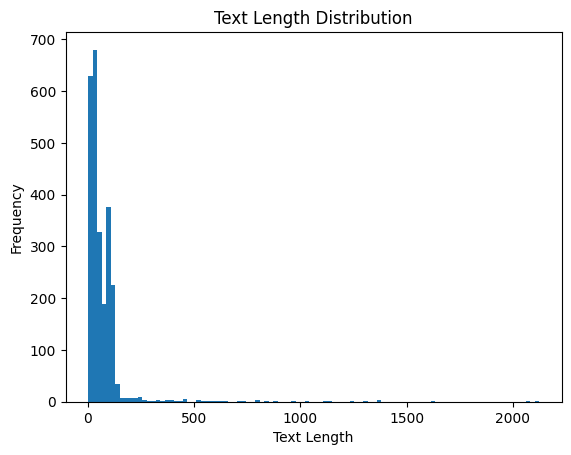

In [58]:
filtered_df = pd.DataFrame({"text_length": [mesure_text_length(text) for text in filtered_dataset["text"]]})

plt.hist(filtered_df["text_length"], bins=100)
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.title("Text Length Distribution")
plt.show()

In [12]:

def semantic_chunk_text(
    raw_text,
    discourse_markers=None,
    similarity_threshold=0.9,
    min_tokens=20,
    max_tokens=120,
    window_overlap=0.9
):
    """
    Splits Tunisian/Arabic text into meaningful semantic chunks with sliding window refinement.

    Args:
        raw_text (str): Original text to split.
        discourse_markers (list[str], optional): Custom markers for splitting.
        similarity_threshold (float): Threshold for semantic shift detection.
        min_tokens (int): Minimum token length to keep a chunk.
        max_tokens (int): Maximum token length before further splitting.
        window_overlap (float): Fraction of tokens to overlap when sliding windows are used.

    Returns:
        list[dict]: List of chunk records with metadata.
    """
    if not raw_text or not isinstance(raw_text, str):
        return []

    # Default discourse markers
    if discourse_markers is None:
        discourse_markers = [
             " لكن ", " ثم ", "بخلاف", "على خاطر", " خاطر ", " بالرغم ", " كيما "
        ]
    original_text_id = str(uuid.uuid4())
    # Step 1: Initial split by punctuation and discourse markers
    pattern = r"[\.؟!…]|" + "|".join([re.escape(m) for m in discourse_markers])
    candidate_chunks = [s.strip() for s in re.split(pattern, raw_text) if s.strip()]
    #print(candidate_chunks)
    refined_chunks = []

    # Step 2: Length filtering + refinement
    for cand in candidate_chunks:
        tokens = cand.split()
        n_tokens = len(tokens)

        # Drop too short
        #print(n_tokens < min_tokens)
        if n_tokens < min_tokens:
            continue

        # If too long, apply sliding window strategy
        if n_tokens > max_tokens:
            step = int(max_tokens * (1 - window_overlap))
            if step < 1:
                step = 1

            for i in range(0, n_tokens, step):
                window_tokens = tokens[i:i+max_tokens]
                if len(window_tokens) >= min_tokens:
                    refined_chunks.append(" ".join(window_tokens))
        else:
            refined_chunks.append(cand)

    # Step 3: Merge adjacent windows if semantically close
    if len(refined_chunks) > 1:
        embeddings = embedding_model.encode(refined_chunks)
        merged = []
        current_group = [refined_chunks[0]]

        for i in range(1, len(refined_chunks)):
            sim = float(
                embeddings[i-1].dot(embeddings[i]) /
                (np.linalg.norm(embeddings[i-1]) * np.linalg.norm(embeddings[i]))
            )
            if sim > similarity_threshold:
                current_group.append(refined_chunks[i])
            else:
                merged.append(" ".join(current_group))
                current_group = [refined_chunks[i]]

        if current_group:
            merged.append(" ".join(current_group))

        refined_chunks = merged

    # Step 4: Build structured output with metadata
    chunk_records = []
    for idx, chunk in enumerate(refined_chunks):
        record = {
            "chunk_id": str(uuid.uuid4()),
            "original_text_id": original_text_id,
            "original_text": raw_text,
            "chunk_text": chunk,
            "position": idx,
            "num_chunks_in_doc": len(refined_chunks),
            "num_tokens": len(chunk.split())
        }
        chunk_records.append(record)

    return chunk_records


In [13]:
def process_batch(batch):
    """Apply semantic chunking to each row in a dataset batch."""
    all_chunks = []
    for text in batch["text"]:
        chunks = semantic_chunk_text(text,min_tokens=7,max_tokens=120,window_overlap=0.7,similarity_threshold=0.7)
        all_chunks.extend(chunks)
    return {
        "chunk_id": [c["chunk_id"] for c in all_chunks],
        "chunk_text": [c["chunk_text"] for c in all_chunks],
        "original_text_id": [c["original_text_id"] for c in all_chunks],
        "original_text": [c["original_text"] for c in all_chunks],
        "position": [c["position"] for c in all_chunks],
        "num_chunks_in_doc": [c["num_chunks_in_doc"] for c in all_chunks],
        "num_tokens": [c["num_tokens"] for c in all_chunks],
    }

In [14]:
chunked_dataset = filtered_dataset.map(process_batch, batched=True, remove_columns=filtered_dataset.column_names)

Map:   0%|          | 0/2559 [00:00<?, ? examples/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
print(chunked_dataset)

Dataset({
    features: ['chunk_id', 'chunk_text', 'original_text_id', 'original_text', 'position', 'num_chunks_in_doc', 'num_tokens'],
    num_rows: 1783
})


In [16]:
chunked_df =pd.DataFrame(chunked_dataset)

In [17]:
chunked_df["text_length"] = chunked_df["chunk_text"].apply(lambda x: len(x))

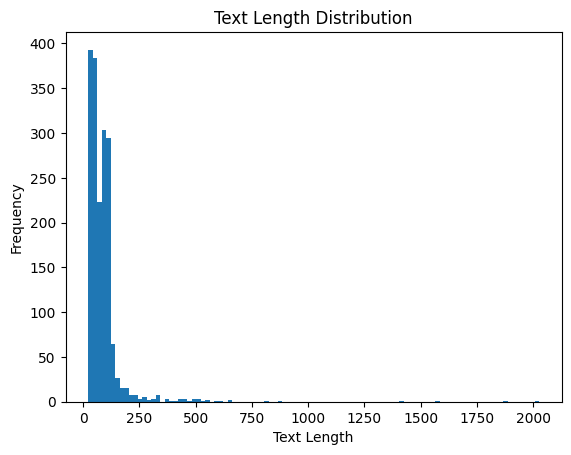

In [18]:
plt.hist(chunked_df["text_length"], bins=100)
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.title("Text Length Distribution")
plt.show()

In [19]:
chunked_df.query("text_length < 1000")

,chunk_id,chunk_text,original_text_id,original_text,position,num_chunks_in_doc,num_tokens,text_length
0,c90f26ab-ffac-4b46-ae2e-caa4518c45a7,محنية و لابسة غربال ذهب مدام تيريزا الجارة الط...,1531d7aa-12cc-4311-92d9-00928673a3b5,محنية و لابسة غربال ذهب مدام تيريزا الجارة الط...,0,1,21,111
1,a0e1e90e-7022-4ad2-a93d-ae4c9dbd1935,بلعتو في الديون و ما عادش قادر على مجابهة المص...,c2002884-5b7b-4cd1-a0ae-89d87b0b702d,بلعتو في الديون و ما عادش قادر على مجابهة المص...,0,1,20,95
2,37c4a8d7-1aa4-4014-b61a-e95c403508c1,مليكة يالا غدوة على الصباح إيجا انت أقعد بحذا ...,0cf667f7-e77f-4152-ae9d-de0a809418a7,مليكة يالا غدوة على الصباح إيجا انت أقعد بحذا ...,0,1,21,113
3,1e276c1e-ed4a-4326-b743-14c2c5b9a8d9,و إلي يلعب خير أحنا روح رياضية أحنا إلي يلعب خ...,8668f27e-4d35-4d0d-821a-a7f8ae66fe31,و إلي يلعب خير أحنا روح رياضية أحنا إلي يلعب خ...,0,1,14,64
4,4866626b-c39c-46d2-bc3b-bd07c67efc8f,قال خوي جى في الصباح و بعد قص قال أنا مشيت خدم...,bbcfb33c-dce3-4421-a871-3ef4cd451dcd,قال خوي جى في الصباح و بعد قص قال أنا مشيت خدم...,0,1,15,63
...,...,...,...,...,...,...,...,...
1778,4b0aec88-e21a-4548-b2f0-fe3570473a48,على هذاكة تقلعها قبل ما أه تشق عليها ما تتقلعش...,443e7fcf-1c7b-4eb0-82d3-7d1b0e48f47f,على هذاكة تقلعها قبل ما أه تشق عليها ما تتقلعش...,0,1,11,52
1779,d1e7370b-6298-4b61-8ca8-ebebb2b546e1,أما أنا خايفة كان يجيني أدوميسيل ما يعجبنيش,9b8a6e47-4bd1-4b14-bf41-1a272fe5d382,أما أنا خايفة كان يجيني أدوميسيل ما يعجبنيش,0,1,8,43
1780,164a75ee-2a41-4e66-a3fc-9e773cb20a5a,هاني نحضر في روحي شوية نصلي نتوضى ونمشي نخرج ا...,1729b97e-4028-4f39-b50f-3d3b8da71689,هاني نحضر في روحي شوية نصلي نتوضى ونمشي نخرج ا...,0,1,10,50
1781,cc018c73-5d18-4969-bfde-800c45c74b62,شوف حل لعمرك يا سي البهيم ما نعرفش الناس هذي و...,2ccd5345-8ebb-42d5-a80c-376c4d90e168,شوف حل لعمرك يا سي البهيم ما نعرفش الناس هذي و...,0,1,21,89


In [40]:
model_id = "facebook/nllb-200-distilled-600M"
# tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
# model = AutoModelForCausalLM.from_pretrained(
#     model_id,
#     device_map="auto",
#     trust_remote_code=True,
# )

# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("Murhaf/AraT5-MSAizer")
model = AutoModelForSeq2SeqLM.from_pretrained("Murhaf/AraT5-MSAizer")

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/835 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [64]:
import time
import random
import gc
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import Dataset
from huggingface_hub import HfApi, HfFolder
import os

# ============================
# CONFIG
# ============================
USE_GROQ = True
GROQ_AVAILABLE = True
GROQ_MODELS = [
    "allam-2-7b",
    "deepseek-r1-distill-llama-70b",
    "gemma2-9b-it",
    "groq/compound",
    "groq/compound-mini",
    "llama-3.1-8b-instant",
    "llama-3.3-70b-versatile",
    "meta-llama/llama-4-maverick-17b-128e-instruct",
    "meta-llama/llama-4-scout-17b-16e-instruct",
    "meta-llama/llama-guard-4-12b",
    "meta-llama/llama-prompt-guard-2-22m",
    "meta-llama/llama-prompt-guard-2-86m",
    "moonshotai/kimi-k2-instruct",
    "moonshotai/kimi-k2-instruct-0905",
    "openai/gpt-oss-20b",
    "openai/gpt-oss-120b",
    "qwen/qwen3-32b",
    
    

]

# ============================
# TRANSLATION FUNCTIONS
# ============================

            
            
def translate_tn_to_msa_local(tn_sentence):
    """Translate Tunisian Arabic to MSA using local Qwen."""
    try:
        prompt =  f"""
                    مثال 1:
                    - التونسية: «اليوم الطقس باهي برشة»
                    - الفصحى: «الطقس اليوم جميل جداً»

                    مثال 2:
                    - التونسية: «شنوّة تعمل غدوة؟»
                    - الفصحى: «ماذا ستفعل غداً؟»
                    الآن ترجّم هذه الجملة التونسية إلى العربية الفصحى مع المحافظة على المعنى والأسلوب:
                    الجملة: «{tn_sentence}»
                    الترجمة: ____________________
                    """
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        outputs = model.generate(**inputs, max_new_tokens=100)
        return tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
    except Exception as e:
        print(f"❌ Local error on '{tn_sentence}': {e}")
        return None


def translate_tn_to_msa_groq(tn_sentence, groq_client, model_id):
    """Translate using Groq API with given model_id."""
    try:
        prompt =  f"""
            مثال 1:
            - التونسية: «اليوم الطقس باهي برشة»
            - الفصحى: «الطقس اليوم جميل جداً»

            مثال 2:
            - التونسية: «شنوّة تعمل غدوة؟»
            - الفصحى: «ماذا ستفعل غداً؟»
            الآن ترجّم هذه الجملة التونسية إلى العربية الفصحى مع المحافظة على المعنى والأسلوب:
            الجملة: «{tn_sentence}»
            الترجمة: ____________________
            """
        resp = groq_client.chat.completions.create(
            messages=[{"role": "user", "content": prompt}],
            model=model_id,
            temperature=0.2,
            max_tokens=512,
        )
        print(model_id,resp)
        return resp.choices[0].message.content.strip()
    except Exception as e:
        print(f"❌ Groq error with {model_id}: {e}")
        return None


def translate_tn_to_msa(tn_sentence, groq_client=None):
    """Wrapper: try Groq models in order, fallback to local."""
    if USE_GROQ and GROQ_AVAILABLE and groq_client is not None:
        for m in GROQ_MODELS:
            out = translate_tn_to_msa_groq(tn_sentence, groq_client, m)
            if out:
                return out
            else:
                print(f"⚠️ Switching model (failed {m})")
                time.sleep(1)  # small backoff before next model
    # fallback
    return translate_tn_to_msa_local(tn_sentence)

# ============================
# BATCH TRANSLATION (with fallback logic)
# ============================

def batch_translate(batch, groq_client=None, max_length=128, max_new_tokens=64):
    """Batch translation with Groq→Local fallback."""
    results = []
    for s in batch["chunk_text"]:
        translation = translate_tn_to_msa(s, groq_client)
        results.append(translation if translation else "")
    return {"msa_translation": results}


# ============================
# CHUNKED PROCESSING + SAVE
# ============================

# def process_dataset(chunked_dataset, groq_client=None, step=1000, batch_size=8):
#     for i in range(0, len(chunked_dataset), step):
#         subset = chunked_dataset.select(range(i, min(i+step, len(chunked_dataset))))

#         subset = subset.map(
#             lambda ex: batch_translate(ex, groq_client),
#             batched=True,
#             batch_size=batch_size
#         )

#         df = pd.DataFrame(subset)
#         df.to_parquet(f"msa_translations_part_{i//step}.parquet")

#         # cleanup
#         del subset, df
#         torch.cuda.empty_cache()
#         gc.collect()
#         print(f"✅ Saved chunk {i//step}, rows {i}–{min(i+step, len(chunked_dataset))}")


def process_and_push(chunked_dataset, repo_id, groq_client=None, step=1000, batch_size=8):
    for i in range(0, len(chunked_dataset), step):
        subset = chunked_dataset.select(range(i, min(i+step, len(chunked_dataset))))

        subset = subset.map(
            lambda ex: batch_translate(ex, groq_client),
            batched=True,
            batch_size=batch_size
        )

        # convert to HF Dataset
        hf_subset = Dataset.from_pandas(pd.DataFrame(subset))

        # push incrementally
        hf_subset.push_to_hub(repo_id, split=f"part_{i//step}")
        # cleanup
        del subset, hf_subset
        torch.cuda.empty_cache()
        gc.collect()

        print(f"✅ Pushed chunk {i//step} to Hugging Face Hub")


In [65]:
process_and_push(chunked_dataset, repo_id="tunis-ai/tunisian-msa-parallel-corpus", groq_client=groq_client, step=1000, batch_size=8)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

allam-2-7b ChatCompletion(id='chatcmpl-4511a984-de5c-43a8-a248-6ceb6233aff6', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='بالطبع، سأقوم بترجمة الجملة التونسية المعطاة إلى العربية الفصحى مع الحفاظ على المعنى والأسلوب. إليك الترجمة:\n\n"أرى امرأة منحنية وترتدي قناع ذهب للسيدة تيريزا، الجارة الإيطالية، تقوم بالكنس والملء في الجرة كما تفعل جارتي وسيلة كل يوم. خالتك وسيلة هي التي تقص الحكايات عن أم حنبعل."\n\nتتميز هذه الترجمة ببقاء الأسلوب العام والتعبير المحلي المستخدم في اللهجة التونسية، مع توفير المعنى بالعربية الفصحى. ', role='assistant', executed_tools=None, function_call=None, reasoning=None, tool_calls=None))], created=1758196365, model='allam-2-7b', object='chat.completion', system_fingerprint='fp_ff744b2c7a', usage=CompletionUsage(completion_tokens=103, prompt_tokens=217, total_tokens=320, completion_time=0.073856825, prompt_time=0.006521379, queue_time=0.183742462, total_time=0.080378204), usage_breakdown=None, x_groq={'id'

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading...:   0%|          | 0.00/523k [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

✅ Pushed chunk 0 to Hugging Face Hub


Map:   0%|          | 0/783 [00:00<?, ? examples/s]

allam-2-7b ChatCompletion(id='chatcmpl-d7409bc4-2284-405a-973e-daa18d53ed73', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='بالطبع، يمكنني مساعدتك في ترجمة العبارات التونسية إلى العربية الفصحى مع الحفاظ على المعنى والأسلوب. إليك الترجمة للعبارة التونسية التي قدمتها:\n\n"مش بالعفط هذا ولمجرد تعبئة الفراغات يعني، أنا آسف"\n\nالترجمة: لستُ هنا للتظاهر فقط وملء الفراغات، أعتذر عن ذلك. ', role='assistant', executed_tools=None, function_call=None, reasoning=None, tool_calls=None))], created=1758199422, model='allam-2-7b', object='chat.completion', system_fingerprint='fp_ff744b2c7a', usage=CompletionUsage(completion_tokens=67, prompt_tokens=197, total_tokens=264, completion_time=0.048029521, prompt_time=0.005905149, queue_time=0.183845494, total_time=0.05393467), usage_breakdown=None, x_groq={'id': 'req_01k5edm73meqfby756hz3zb3fq'}, service_tier='on_demand')
allam-2-7b ChatCompletion(id='chatcmpl-01b6b07c-6df7-4469-bcbd-232c3ce47d03', cho

KeyboardInterrupt: 

In [66]:
subset

NameError: name 'subset' is not defined

In [ ]:
s = "صحيح انا في الضيق اما حتى وانا في الضيق مضيقها لبرشا منيكين"
prompts =  f"""
            مثال 1:
            - التونسية: «اليوم الطقس باهي برشة»
            - الفصحى: «الطقس اليوم جميل جداً»

            مثال 2:
            - التونسية: «شنوّة تعمل غدوة؟»
            - الفصحى: «ماذا ستفعل غداً؟»
            الآن ترجّم هذه الجملة التونسية إلى العربية الفصحى مع المحافظة على المعنى والأسلوب:
            الجملة: «{s}»
            الترجمة: ____________________
            """

# Tokenize with truncation + padding
inputs = tokenizer(
    prompts,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=150,
).to(model.device)

with torch.inference_mode():
    outputs = model.generate(**inputs, max_new_tokens=150)

decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)